# 简介
就像SVMs一样，决策树也是一个可以分类，回归，甚至还能支持多输出的模型，可以适应复杂数据集。  
决策树还是随机森林的基础，随机森林是如今可选的强有力的算法之一。  
# 训练并可视化一棵决策树 

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[: ,2:] #petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

我们可以使用export_graphviz()方法，来输出决策树模型

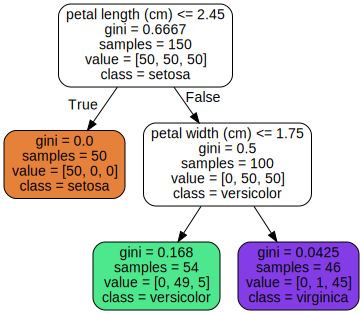

In [2]:
from sklearn.tree import export_graphviz
import graphviz

dot_data=export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)
graph = graphviz.Source(dot_data)
graph

# 做预测
我们来看看决策树如何进行分类：  
首先从根节点开始，先判断petal length是否大于2.45cm，如果否，我们则移至左侧孩子节点，这是一个叶节点，所以没有任何的继续判断问题，可以将类分为class=setosa。  
决策树不需要范围缩放。  
samples表示有多少样例分到这个节点。  
gini表示该节点的“纯度”，当gini为0时，该节点的样例都是同一个类，来自下式：  
$G_i=1-\sum_{k=1}^np_{i,k}^2$  
其中$p_{i,k}$是第i个节点中属于k类的比例。

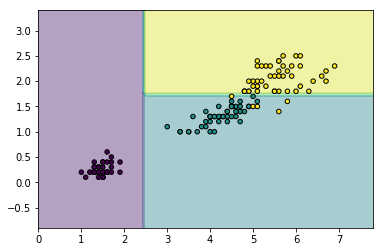

In [3]:
#绘制决策限
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')

plt.show()

# 模型释义：白盒和黑盒
决策树模型非常容易解释，这种模型称为白盒模型。而随机森林和神经网络通常不易解释，称为黑盒模型。
# 评估属于某类的概率
sklearn根据输入的数据计算数据属于哪一个叶子结点，然后计算其属于每一类的概率，并返回概率最大的类。

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[ 0.        ,  0.90740741,  0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

# CART训练算法
sklearn中使用Classification And Regression Tree(CART)算法生成决策树，思路很简单：  
首先算法使用一个特征$k$和一个阈值$t_k$将训练集分成两部分：是通过寻找能产生“最纯”子集确定的一组参数,它的损失函数如下:  
$J(k,t_k)=\frac{m_l}{m}G_l + \frac{m_r}{m}G_r$  
其中$G_{l/r}$评估左右子集的不纯度；$m_{l/r}$是左右子集的样例数目。
一旦成功分割子集，就递归地对子集进行分割，直至达到最大深度，或者分割不能够减少不纯度。还有一些超参数有额外的停止条件。  
我们能看到CART是贪婪算法：贪婪地每层制造最优分割，而不检测是否分割达到整局最优，贪婪算法通常能产生合理的结果，但是不是最优的。  
不幸的是，找到最优树是一个完全NP问题：需要$O(exp(m))$的时间去求解，所以合理的好结果是不错的。  
# 计算复杂度
做出预测需要穿过这棵树，大致需要$O(log_2(m))$的时间，因此预测十分迅速。  
然而训练这棵树需要在每个节点对所有样例比较每个特征，因此训练复杂度是$O(n\times mlog_2(m))$。  
对于较小的数据集（几千以下）sklearn可以通过预排序加快树的生成(presort=True)。
# Gini 不纯度还是熵？
默认使用Gini，可以通过设置criterion来使用熵，熵一开始是热学表示分子异常的工具，当其为0时，所有分子排列有序。后来被使用到信息学，用来表示一条信息带有多少信息量，当其为0时，表示所有信息是同一个。在这里，一个子集的熵为0表示他们只属于一个类。熵的减小称为信息增益，下式表示第i个节点的熵：  
$H_i=-\sum_{k=1,p_{i,k\ne0}}^np_{i,k}log(p_{i,k})$  
所以应该使用哪个判断依据呢，事实上多数情况下两者不会有太大区别，将会生成相似的树。Gini计算更加快速，所以是不错的默认值。Gini趋向于将最频繁的类分隔在自己的分支中，而熵更趋向于树平衡。
# 正则化参数
决策树仅对样例做少量预测，如果不受约束，树会改变结构自己适应样例，很可能过拟合。这种模型叫无参模型(nonparametric model)，不仅是参数数值没有，连参数该有哪些也没定下来，这会导致模型结构十分接近数据。  
为了避免过拟合，sklearn有很多控制树形状的超参数:max_depth,min_sample_split,min_samples_lead,min_weight_fraction_leaf等。  
# 剪枝
剪枝算法首先在不约束的情况下生成树，然后去掉不必要的节点：节点的孩子全是叶子节点，且不能统计显著的提高纯度的就认为该节点不必要。
# 回归
决策树也能用来完成回归任务。

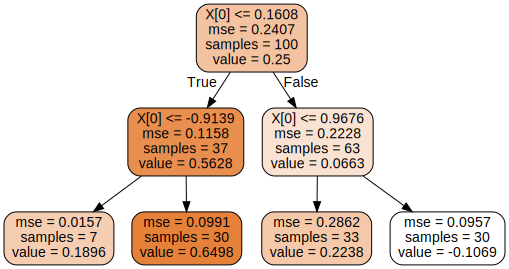

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_moons

X, y = make_moons(random_state=42)
X_0 = X[:,0].reshape(-1, 1)
X_1 = X[:,1].reshape(-1, 1)
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_0, X_1)

dot_data=export_graphviz(
    tree_reg,
    out_file=None,
    rounded=True,
    filled=True
)
graph = graphviz.Source(dot_data)
graph

这棵树看起来和分类树很像，主要的区别在于每个节点不是预测类别，而是预测值。预测值是该节点样例的平均值。

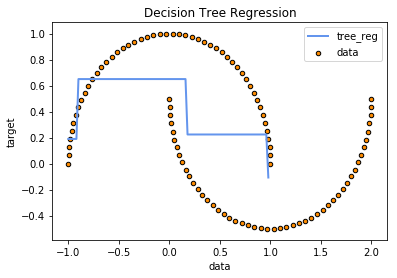

In [41]:
# Plotting decision regions

# Predict
X_test = np.arange(-1, 1, 0.02).reshape(-1, 1)
y_predict = tree_reg.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X_0, X_1, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_predict, color="cornflowerblue", label="tree_reg", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


CART 回归损失函数  
$J(k,t_k)=\frac{m_l}{m}MSE_l+\frac{m_r}{m}MSE_r$  
$\text{where }\left{\begin{array}{ll}
MSE_{node}=\sum_{i\in node}(\hat y_{node}-y^{(i)})^2\\
\hat y_{node}=\frac{1}{m_{node}}\sum_{i\in node}y^{(i)}
\end{array}\right. $  
和分类一样，回归也容易过拟合，需要正则化。  
# 不稳定性
决策树的不足：  
首先，它的决策限是正交的，所以对训练集的角度敏感，一个能限制这种情况的方法是使用PCA，可以将训练集放在一个比较好的方向。  
另外，决策树还对数据集的小方差敏感，它的生成过程也是随机的，随机地选择一个特征去评估每个节点，随机森林可以限制决策树的不稳定性，得出大多数树的平均预测结果。